 ### “Welche Cluster existieren im Wine Quality Dataset basierend auf chemischen Eigenschaften und wie unterscheiden sich diese Cluster in ihrer Qualität?”
...


### Lade den Datensatz.

In [87]:
import os
os.environ["OMP_NUM_THREADS"] = "7"

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [88]:
# Import required libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

data = pd.read_csv('dataset/winequality-red.csv', sep=",")

### Zielfeature abgrenzen von anderen Daten

In [89]:
# Separate features and output
print(data.columns)
y = data["quality"]
X = data.drop("quality", axis=1)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


### Merkmale standardisieren

In [90]:
# Step 3. Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### k-Cluster für K-MEANS ermitteln

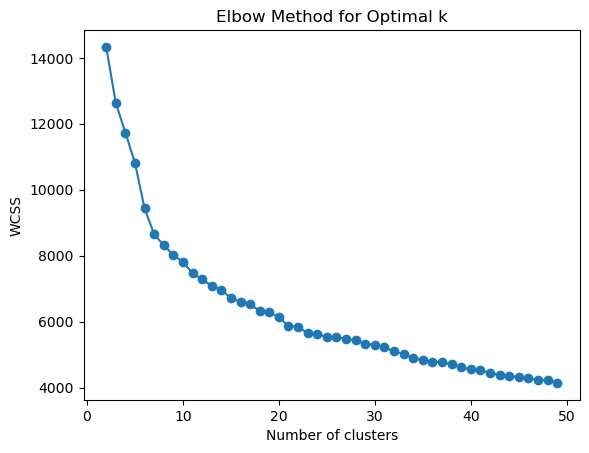

In [91]:
# Step 4. Determine optimal number of clusters (Elbow method)
wcss = []
range_n_clusters = range(2, 50)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure()
plt.plot(range_n_clusters, wcss, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

### Ausführen von K-MEANS

In [92]:
# Step 5. Fit KMeans with chosen number of clusters (e.g. k=3)
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)
clusters = kmeans.labels_

# Create DataFrame with cluster assignments
X_clustered = pd.DataFrame(X_scaled, columns=X.columns)
X_clustered['Cluster'] = clusters
X_clustered['Quality'] = y.values

# Calculate cluster centers (mean standardized feature values per cluster)
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

### Qualität pro Cluster ermitteln

In [93]:
# Quality per Cluster for k-means
quality_per_cluster = X_clustered.groupby("Cluster")["Quality"].mean()
print("\nAverage Quality per Cluster:")
print(quality_per_cluster)


Average Quality per Cluster:
Cluster
0    5.329140
1    5.652850
2    5.291667
3    5.384615
4    6.385714
5    5.545455
6    5.220513
7    5.847222
8    5.400000
9    5.870849
Name: Quality, dtype: float64


### Ermitteln welche Merkmale in den jeweiligen Clustern (Zentroiden) enthalten sind

In [94]:
cluster_centers_original = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_),
                                        columns=X.columns)
print("\nCluster centers (original feature units):")
print(cluster_centers_original)


Cluster centers (original feature units):
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       7.594340          0.642296     0.116981        2.241405   0.085503   
1       7.396891          0.459404     0.220363        2.126943   0.076223   
2       8.441667          0.523542     0.541667        1.987500   0.399667   
3       7.733333          0.562179     0.309744        6.815385   0.095026   
4       8.413810          0.347214     0.408429        2.308810   0.073500   
5       8.854545          0.413636     0.394545       13.190909   0.123455   
6       8.495897          0.604051     0.289795        2.524359   0.089272   
7       6.229861          0.630868     0.078542        2.235417   0.066312   
8       9.337143          0.486286     0.377143        2.394286   0.098886   
9      11.084502          0.410830     0.511993        2.725092   0.088022   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            10.411

### Korrelationskoeffizient zwischen Qualität und den Merkmalsausprägungen in den Clustern ermitteln

In [95]:
quality_per_cluster = quality_per_cluster.reset_index()
cluster_centers_original['Cluster'] = quality_per_cluster['Cluster']
cluster_centers_original['Average_Quality'] = quality_per_cluster['Quality']

print(cluster_centers_original)

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       7.594340          0.642296     0.116981        2.241405   0.085503   
1       7.396891          0.459404     0.220363        2.126943   0.076223   
2       8.441667          0.523542     0.541667        1.987500   0.399667   
3       7.733333          0.562179     0.309744        6.815385   0.095026   
4       8.413810          0.347214     0.408429        2.308810   0.073500   
5       8.854545          0.413636     0.394545       13.190909   0.123455   
6       8.495897          0.604051     0.289795        2.524359   0.089272   
7       6.229861          0.630868     0.078542        2.235417   0.066312   
8       9.337143          0.486286     0.377143        2.394286   0.098886   
9      11.084502          0.410830     0.511993        2.725092   0.088022   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            10.411950             31.431866  0.996744  3.3605

In [96]:
# Calculate Pearson correlation for each feature vs Average_Quality
correlations = {}

for feature in X.columns:
    corr = cluster_centers_original[[feature, 'Average_Quality']].corr().iloc[0,1]
    correlations[feature] = corr

# Convert to DataFrame for better readability
correlations_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation_with_Quality'])
correlations_df = correlations_df.sort_values(by='Correlation_with_Quality', ascending=False)

print(correlations_df)

                      Correlation_with_Quality
alcohol                               0.830689
pH                                    0.264338
citric acid                           0.084055
fixed acidity                         0.058837
residual sugar                       -0.116948
sulphates                            -0.241314
chlorides                            -0.362773
free sulfur dioxide                  -0.363138
density                              -0.419333
total sulfur dioxide                 -0.611425
volatile acidity                     -0.625599


Die berechneten Pearson-Korrelationen zwischen den mittleren Merkmalsausprägungen der Cluster und deren durchschnittlicher Qualitätsbewertung zeigen, ob Cluster mit zb höheren Alkoholwerten tendenziell eine höhere Qualität aufweisen. Aufgrund der geringen Anzahl an Clustern dienen diese Werte jedoch ausschließlich der explorativen Interpretation.

Clusters mit höherem durchschnittlichen Alkohol tendieren dazu, höhere durchschnittliche Qualität zu haben.

Text(0.5, 1.0, 'Average Linkage')

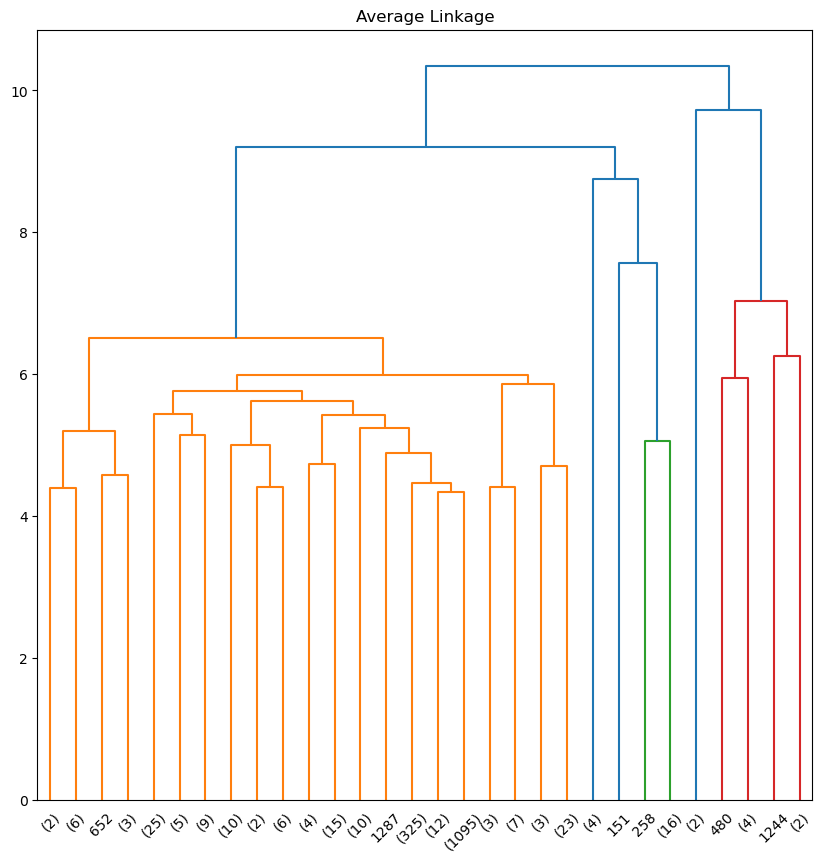

In [97]:
from scipy.cluster.hierarchy import linkage, dendrogram

hierarchy_average = linkage(X_scaled, method='average')

fig, axes = plt.subplots(1, 1, figsize=(10, 10))

dendrogram(hierarchy_average, ax=axes, truncate_mode='lastp', p=30)
axes.set_title('Average Linkage')

In [98]:
from scipy.cluster.hierarchy import fcluster

cutoff_distance = 7
hierarchy_chosen = fcluster(hierarchy_average, t=cutoff_distance, criterion='distance')

In [99]:
# Create DataFrame with cluster assignments
X_clustered_hierarchy = data.copy()
X_clustered_hierarchy['Cluster'] = hierarchy_chosen

In [100]:
# Exclude 'quality' if you want only chemical features
hierarchical_cluster_means = X_clustered_hierarchy.groupby('Cluster')[X.columns].mean()
print("\nHierarchical cluster centers (average chemical values):")
print(hierarchical_cluster_means)


Hierarchical cluster centers (average chemical values):
         fixed acidity  volatile acidity  citric acid  residual sugar  \
Cluster                                                                 
1             8.319719          0.528720     0.266228        2.480696   
2             8.225000          0.445000     0.287500        2.000000   
3             8.229412          0.546471     0.536471        1.776471   
4             9.200000          0.520000     1.000000        3.400000   
5             7.900000          0.300000     0.680000        8.300000   
6            10.160000          0.472000     0.426000       14.780000   
7             5.833333          0.310000     0.450000       13.400000   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
Cluster                                                                   
1         0.083366            15.698149             45.596043  0.996728   
2         0.095750            23.750000            133.00000

In [101]:
hierarchical_quality_means = X_clustered_hierarchy.groupby('Cluster')["quality"].mean()
print("\nAverage wine quality per hierarchical cluster:")
print(hierarchical_quality_means)


Average wine quality per hierarchical cluster:
Cluster
1    5.640715
2    5.500000
3    5.294118
4    4.000000
5    7.000000
6    5.400000
7    5.333333
Name: quality, dtype: float64


In [102]:
# Combine cluster means with average quality for hierarchical clustering
hierarchical_cluster_means = hierarchical_cluster_means.copy()
hierarchical_cluster_means['Average_Quality'] = hierarchical_quality_means

# Calculate Pearson correlation for each feature vs Average_Quality
correlations_hierarchical = {}

for feature in X.columns:
    corr = hierarchical_cluster_means[[feature, 'Average_Quality']].corr().iloc[0,1]
    correlations_hierarchical[feature] = corr

# Convert to DataFrame
correlations_df_hierarchical = pd.DataFrame.from_dict(correlations_hierarchical, orient='index', columns=['Correlation_with_Quality'])
correlations_df_hierarchical = correlations_df_hierarchical.sort_values(by='Correlation_with_Quality', ascending=False)

print("\nHierarchical clustering feature-quality correlations:")
print(correlations_df_hierarchical)


Hierarchical clustering feature-quality correlations:
                      Correlation_with_Quality
alcohol                               0.757645
total sulfur dioxide                  0.754524
pH                                    0.351487
residual sugar                        0.198048
free sulfur dioxide                   0.124881
fixed acidity                        -0.247508
citric acid                          -0.372990
volatile acidity                     -0.593996
density                              -0.628539
sulphates                            -0.659214
chlorides                            -0.772082


In [103]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

# Fit PCA to standardized data
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Convert to DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2','PC3'])


In [104]:
pca_df['KMeans_Cluster'] = clusters
# Create interactive 3D scatter plot
fig_kmeans = px.scatter_3d(pca_df,
                           x='PC1', y='PC2', z='PC3',
                           color='KMeans_Cluster',
                           title='K-Means Clusters visualized with 3D PCA')


# Adjust figure dimensions (increase height)
fig_kmeans.update_layout(width=900, height=800)  # adjust height as needed

# Show interactive plot
fig_kmeans.show()


In [105]:
# Add Hierarchical cluster labels
pca_df['Hierarchical_Cluster'] = hierarchy_chosen

fig_hierarchical = px.scatter_3d(pca_df,
                           x='PC1', y='PC2', z='PC3',
                           color='Hierarchical_Cluster',
                           title='Hierarchical Clusters visualized with 3D PCA')


# Adjust figure dimensions (increase height)
fig_hierarchical.update_layout(width=900, height=800)  # adjust height as needed

# Show interactive plot
fig_hierarchical.show()
